# Classification
This file includes code which classifies text chunks as (Austen, Shelly, Kafka, Tolstoy or Dostoyevsky).
The training data is text chunks from their respective works _Pride and predjudice_, _Frankenstein_, _The trial_, _Anna Karenina_ and _Crime and punishment_. We obtain the texts from the Gutenberg Project.

## Importing the data

In [27]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from textdataset import TextDataset
from neural_net import NeuralNet

We use the `mixedbread-ai`-embedding model from Huggingface

In [4]:
def embed(chunks):
    embeddings = []
    for chunk in chunks:
        embeddings.append( model.encode(chunk) )
    return np.asarray(embeddings)

Embedding the texts

In [5]:
# Change max_len and run on clusters - this might take days on the full dataset (but then will never have to be done again:)
folder = ".."
subfolder = "Texts"
filenames = ['austen', 'dostoyevsky', 'kafka', 'shelley', 'tolstoy']
filepaths = [os.path.join(folder, subfolder, filename) for filename in filenames]

# for filepath in filepaths:
#     print(filepath)
#     chunks = read_chunks(filepath+'.txt') # remove max_len to run on entire text
#     embeddings = embed(chunks)
#     np.save(filepath, embeddings)

In [6]:
# Class encoding (0 through 4, alphabetically)
data = [np.load(filepath+'.npy') for filepath in filepaths]
lengths = [len(author) for author in data]

X = np.vstack( data )
y = np.vstack( [[[i]]*length for i, length in enumerate(lengths)] ) 
print(y)

[[0]
 [0]
 [0]
 ...
 [4]
 [4]
 [4]]


## FFNN / Logistic regression

In [7]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, stratify=y.ravel(), random_state=3)

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

dataset_train = TextDataset(torch.tensor(X_train), y_train)
dataset_test = TextDataset(torch.tensor(X_test), y_test)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

# defining the model, optimizer and loss function
model = NeuralNet()

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training the model

In [17]:
def training_model(dataloader, model, loss_fn, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        # setting the model to train mode
        model.train()
        
        for (X, y) in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()           # resets the gradients

        if epoch % 1 == 0:
            loss = loss.item()
            print(f"Epoch {epoch+1:>4f}      loss: {loss:>7f}")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode 
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():           # gradient computation excluded, unecessary
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(0) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
training_model(dataset_train, model, loss_fn, optimizer, num_epochs=1)

c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1.000000      loss: 0.904832


In [18]:
test_loop(dataset_test, model, loss_fn)

Test Error: 
 Accuracy: 87.7%, Avg loss: 1.027444 



In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode 
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():           # gradient computation excluded, unnecessary
        for X, y in dataloader:
            pred = model(X)

            all_preds.append(pred.argmax())
            all_labels.append(y)

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(0) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return all_preds, all_labels

# Example usage:
# Assuming you have a test dataloader `test_dataloader`, a trained model `model`, and a loss function `loss_fn`
predictions, labels = test_loop(dataset_test, model, loss_fn)

# Compute and print confusion matrix
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(cm)

c:\Users\maria\anaconda3\envs\FYS-STK3155\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Error: 
 Accuracy: 87.7%, Avg loss: 1.027444 

Confusion Matrix:
[[ 452    8    4    9   16]
 [  23  635   20   14  119]
 [   0   29  293    0   13]
 [  10   16    2  267    5]
 [  24   68   17   12 1278]]


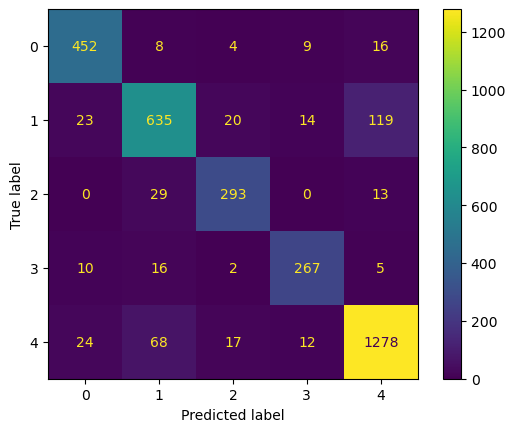

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm).plot()

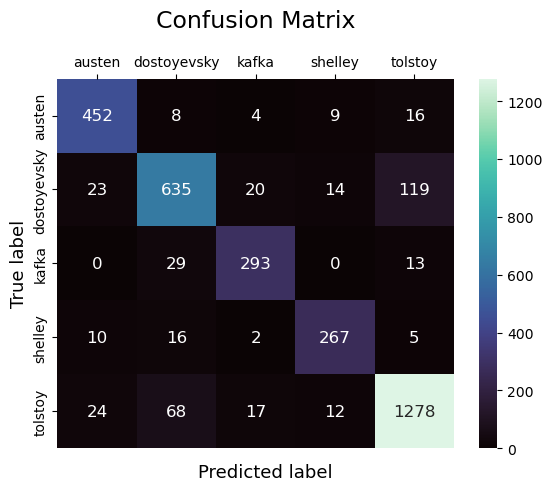

In [35]:
# Plotting the confusion matrix
ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":12},
            fmt=".0f",
            xticklabels=['austen', 'dostoyevsky', 'kafka', 'shelley', 'tolstoy'],
            yticklabels=['austen', 'dostoyevsky', 'kafka', 'shelley', 'tolstoy'],
            cmap='mako')
plt.ylabel('True label', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20, loc='center')
ax.set(xlabel="", ylabel="True label")
ax.xaxis.tick_top()

plt.gca().figure.text(0.45, 0.05, 'Predicted label', ha='center', fontsize=13)
plt.show()

### Scikit-learn wrapping using `skorch`

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
from skorch import NeuralNetClassifier

X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

net = NeuralNetClassifier(
    NeuralNet,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(X, y)
y_proba = net.predict_proba(X)